<a href="https://colab.research.google.com/github/luisaespinoza/CSCI166-project/blob/main/atari_dqn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Purely for demonstration purposes. Long training session were prohibitive in a colab runtime with constant timeouts.
##Actual training was done in the pyscripts ran locally. Provided in the repo https://github.com/luisaespinoza/CSCI166-project/blob/main/atari_dqn_project.ipynb


# Atari DQN / Double DQN Project

This notebook was generated from your original Python modules:

- `envs.py`
- `losses.py`
- `models.py`
- `plotting.py`
- `replay_buffer.py`
- `train.py`

Each of those files is in its own code cell below, so you can run and edit the
whole project directly inside Jupyter.


In [ ]:
# ---- envs.py ----
from __future__ import annotations
from PIL import Image
import os
from dataclasses import dataclass
from typing import Dict, Tuple

import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
import numpy as np
from gymnasium import Wrapper
from gymnasium.vector import SyncVectorEnv
from gymnasium.wrappers import (
    AtariPreprocessing,
    FrameStackObservation,
    RecordEpisodeStatistics,
    RecordVideo,
)



@dataclass
class EnvConfig:
    gym_id: str
    frameskip: int
    grayscale_obs: bool
    screen_size: int
    frame_stack: int

    vec_game: str
    vec_num_envs: int
    vec_frameskip: int
    vec_grayscale: bool
    vec_stack_num: int
    vec_img_height: int
    vec_img_width: int
    vec_maxpool: bool
    vec_reward_clipping: bool
    vec_noop_max: int
    vec_use_fire_reset: bool
    vec_episodic_life: bool

    recordings_dir: str
    recordings_dir_custom: str


@dataclass
class RewardConfig:
    reward_scale: float
    score_weight: float
    survival_reward: float
    termination_penalty: float


class SimpleAtariPreprocessing(gym.Wrapper):
    """
    Minimal drop-in replacement for gymnasium.wrappers.AtariPreprocessing
    that does NOT depend on cv2 / opencv.

    - Resizes to (screen_size, screen_size)
    - Optional grayscale
    - No fancy max-pooling over frames, but good enough for a class project.
    """

    def __init__(
        self,
        env,
        screen_size: int = 84,
        grayscale_obs: bool = True,
        scale_obs: bool = False,  # kept for API compatibility, but ignored
        **kwargs,
    ):
        super().__init__(env)
        self.screen_size = screen_size
        self.grayscale_obs = grayscale_obs

        if grayscale_obs:
            obs_shape = (screen_size, screen_size)
        else:
            obs_shape = (screen_size, screen_size, 3)

        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=obs_shape,
            dtype=np.uint8,
        )

    def _process_obs(self, obs):
        # obs is (H, W, C) from Atari env: uint8 RGB
        img = Image.fromarray(obs)

        # Resize
        img = img.resize((self.screen_size, self.screen_size), Image.BILINEAR)

        # Grayscale if requested
        if self.grayscale_obs:
            img = img.convert("L")   # single channel
            arr = np.array(img, dtype=np.uint8)
        else:
            arr = np.array(img, dtype=np.uint8)

        return arr

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        obs = self._process_obs(obs)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = self._process_obs(obs)
        return obs, reward, terminated, truncated, info
def env_config_from_dict(cfg: Dict) -> EnvConfig:
    env = cfg["env"]
    paths = cfg["paths"]
    return EnvConfig(
        gym_id=env["gym_id"],
        frameskip=env["frameskip"],
        grayscale_obs=env["grayscale_obs"],
        screen_size=env["screen_size"],
        frame_stack=env["frame_stack"],
        vec_game=env["vec_game"],
        vec_num_envs=env["vec_num_envs"],
        vec_frameskip=env["vec_frameskip"],
        vec_grayscale=env["vec_grayscale"],
        vec_stack_num=env["vec_stack_num"],
        vec_img_height=env["vec_img_height"],
        vec_img_width=env["vec_img_width"],
        vec_maxpool=env["vec_maxpool"],
        vec_reward_clipping=env["vec_reward_clipping"],
        vec_noop_max=env["vec_noop_max"],
        vec_use_fire_reset=env["vec_use_fire_reset"],
        vec_episodic_life=env["vec_episodic_life"],
        recordings_dir=paths["recordings_dir"],
        recordings_dir_custom=paths["recordings_dir_custom"],
    )


def reward_config_from_dict(cfg: Dict) -> RewardConfig:
    rw = cfg["reward_wrapper"]
    return RewardConfig(
        reward_scale=rw["reward_scale"],
        score_weight=rw["score_weight"],
        survival_reward=rw["survival_reward"],
        termination_penalty=rw["termination_penalty"],
    )


class CustomRewardWrapper(Wrapper):
    """
    Simple, robust reward shaping for Tetris (ALE/Tetris-v5):

    - env_reward is the ALE score delta
    - each step:
        * small positive survival_reward
        * if no score change: add no_progress_penalty (small negative)
        * if score increased: add score_weight * reward_scale * env_reward
    - on terminal: add a large negative termination_penalty

    Only env_reward is scaled by reward_scale. Everything else (survival, penalties)
    stays in your own shaping units.
    """

    def __init__(
        self,
        env: gym.Env,
        reward_scale: float = 1.0,
        score_weight: float = 5.0,
        survival_reward: float = 0.5,
        no_progress_penalty: float = -0.05,
        termination_penalty: float = -50.0,
    ):
        super().__init__(env)
        self.reward_scale = reward_scale
        self.score_weight = score_weight
        self.survival_reward = survival_reward
        self.no_progress_penalty = no_progress_penalty
        self.termination_penalty = termination_penalty

        # If you want to track cumulative score from info["score"], you can,
        # but for ALE Tetris, env_reward is usually already the score delta.
        self.last_score = 0

    def step(self, action):
        obs, env_reward, terminated, truncated, info = self.env.step(action)

        # Use ALE score if provided, otherwise just trust env_reward as the delta.
        current_score = info.get("score", self.last_score + env_reward)
        score_increase = max(0, current_score - self.last_score)

        # Start with survival reward every step
        shaped = self.survival_reward

        if score_increase > 0:
            # Scoring step (line clears / Tetris rewards)
            # Only env_reward / score_increase gets scaled.
            shaped += self.score_weight * self.reward_scale * score_increase
        else:
            # No progress this step → small penalty so stalling is suboptimal
            shaped += self.no_progress_penalty

        # Big negative at real terminal (game over, not just truncation)
        if terminated:
            shaped += self.termination_penalty

        # Update score tracker
        self.last_score = current_score

        # Reset score tracker on any episode end
        if terminated or truncated:
            self.last_score = 0

        return obs, shaped, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.last_score = info.get("score", 0)
        return obs, info

def make_training_env(env_cfg: EnvConfig, reward_cfg: RewardConfig) -> gym.Env:
    """
    Single Atari env with preprocessing, frame-stack, custom reward.
    """
    env = gym.make(env_cfg.gym_id, render_mode="rgb_array", frameskip=env_cfg.frameskip)
    # env = AtariPreprocessing(
    #     env,
    #     grayscale_obs=env_cfg.grayscale_obs,
    #     terminal_on_life_loss=False,
    #     screen_size=env_cfg.screen_size,
    # )
    env = SimpleAtariPreprocessing(
        env,
        screen_size=84,
        grayscale_obs=True,
        scale_obs=False,
        # frame_skip is ignored in SimpleAtariPreprocessing, but you can still pass it in kwargs if you like.
    )
    env = FrameStackObservation(env, stack_size=env_cfg.frame_stack)
    env = RecordEpisodeStatistics(env)
    env = CustomRewardWrapper(
        env,
        reward_scale=reward_cfg.reward_scale,
        score_weight=reward_cfg.score_weight,
        survival_reward=reward_cfg.survival_reward,
        termination_penalty=reward_cfg.termination_penalty,
    )
    return env


def make_recording_env(
    env_cfg: EnvConfig,
    reward_cfg: RewardConfig | None,
    video_folder: str,
    name_prefix: str,
) -> gym.Env:
    """
    Env used for video recording (optionally with custom reward).
    """
    os.makedirs(video_folder, exist_ok=True)

    env = gym.make(env_cfg.gym_id, render_mode="rgb_array", frameskip=env_cfg.frameskip)
    # env = AtariPreprocessing(
    #     env,
    #     grayscale_obs=env_cfg.grayscale_obs,
    #     terminal_on_life_loss=False,
    #     screen_size=env_cfg.screen_size,
    # )
    env = SimpleAtariPreprocessing(
        env,
        screen_size=84,
        grayscale_obs=True,
        scale_obs=False,
        # frame_skip is ignored in SimpleAtariPreprocessing, but you can still pass it in kwargs if you like.
    )
    env = FrameStackObservation(env, stack_size=env_cfg.frame_stack)

    if reward_cfg is not None:
        env = CustomRewardWrapper(
            env,
            reward_scale=reward_cfg.reward_scale,
            score_weight=reward_cfg.score_weight,
            survival_reward=reward_cfg.survival_reward,
            termination_penalty=reward_cfg.termination_penalty,
        )

    env = RecordVideo(
        env,
        video_folder=video_folder,
        episode_trigger=lambda ep: ep == 0,
        name_prefix=name_prefix,
    )
    return env


def make_vector_envs(env_cfg: EnvConfig, reward_cfg: RewardConfig):
    """
    Two independent vectorized envs built using Gymnasium's SyncVectorEnv.
    No dependency on ale_py.AtariVectorEnv.

    Each vector env runs `vec_num_envs` copies of the training env in parallel.
    """

    def make_single_env():
        # Reuse the same preprocessing + reward wrapper as training
        return make_training_env(env_cfg, reward_cfg)

    # One set of envs for the "single" learner
    vec_single = SyncVectorEnv(
        [make_single_env for _ in range(env_cfg.vec_num_envs)]
    )

    # And a completely separate set for the "double" learner
    vec_double = SyncVectorEnv(
        [make_single_env for _ in range(env_cfg.vec_num_envs)]
    )

    return vec_single, vec_double

def evaluate_and_record(
    model,
    env_cfg: EnvConfig,
    video_folder: str,
    name_prefix: str,
    device,
) -> None:
    """
    Your evaluate_and_record helper, but parameterized and re-usable.
    """
    env = make_recording_env(env_cfg, reward_cfg=None, video_folder=video_folder, name_prefix=name_prefix)
    model.eval()
    obs, _ = env.reset()
    total_reward = 0.0
    steps = 0

    while True:
        import torch  # local import to avoid circulars

        with torch.no_grad():
            state_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            action = model(state_t).argmax(dim=1).item()
        obs, r, term, trunc, info = env.step(action)
        total_reward += float(r)
        steps += 1
        if term or trunc:
            break

    env.close()
    print(
        f"[EVAL] {name_prefix}: reward={total_reward:.2f}, "
        f"steps={steps}, video_dir={video_folder}"
    )


In [ ]:
# ---- losses.py ----
from typing import Tuple

import torch
import torch.nn as nn


def compute_loss(
    batch: Tuple[torch.Tensor, ...],
    model: nn.Module,
    target_model: nn.Module,
    gamma: float,
) -> torch.Tensor:
    """
    Standard DQN loss, using the model and target_model arguments
    (mirrors your notebook).
    """
    states, actions, rewards, next_states, dones = batch

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_model(next_states).max(1)[0].detach()

    target_q_values = rewards + gamma * next_q_values * (1.0 - dones)
    loss = nn.MSELoss()(current_q_values, target_q_values)
    return loss


def compute_loss_double_dqn(
    batch: Tuple[torch.Tensor, ...],
    model: nn.Module,
    target_model: nn.Module,
    gamma: float,
) -> torch.Tensor:
    """
    Double DQN loss
    """
    states, actions, rewards, next_states, dones = batch

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_actions = model(next_states).argmax(dim=1)
        next_q_values = (
            target_model(next_states)
            .gather(1, next_actions.unsqueeze(1))
            .squeeze(1)
        )

    target_q_values = rewards + gamma * next_q_values * (1.0 - dones)
    loss = nn.MSELoss()(current_q_values, target_q_values)
    return loss


In [ ]:
# ---- models.py ----
from typing import Tuple

import torch
import torch.nn as nn


class DQN(nn.Module):
    """
    Conv DQN for Atari input: (C, H, W).
    Mirrors the architecture you had in the notebook.
    """

    def __init__(self, input_shape: Tuple[int, int, int], num_actions: int) -> None:
        super().__init__()
        c, _, _ = input_shape

        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self._output_size = self._get_conv_output_size(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(self._output_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def _get_conv_output_size(self, input_shape: Tuple[int, int, int]) -> int:
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            out = self.conv(dummy)
            return out.view(1, -1).size(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # match notebook behaviour: normalize by 255 in the conv branch
        x = self.conv(x / 255.0)
        x = x.view(x.size(0), -1)
        return self.fc(x)


def build_dqn_pair(
    input_shape: Tuple[int, int, int],
    num_actions: int,
    device: torch.device,
):
    """
    Build (single_DQN, target_single, double_DQN, target_double)
    just like the notebook, but packaged.
    """
    single = DQN(input_shape, num_actions).to(device)
    double = DQN(input_shape, num_actions).to(device)

    target_single = DQN(input_shape, num_actions).to(device)
    target_double = DQN(input_shape, num_actions).to(device)

    target_single.load_state_dict(single.state_dict())
    target_double.load_state_dict(double.state_dict())

    target_single.eval()
    target_double.eval()

    return single, target_single, double, target_double


In [ ]:
# ---- replay_buffer.py ----
from __future__ import annotations

import collections
import random
from typing import Deque, Tuple

import numpy as np
import torch


class ReplayBuffer:
    """
    Same semantics as in the notebook, but no hidden globals:
    device is passed in via the constructor.
    """

    def __init__(self, capacity: int, device: torch.device) -> None:
        self.buffer: Deque = collections.deque(maxlen=capacity)
        self.device = device

    def __len__(self) -> int:
        return len(self.buffer)

    def push(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ) -> None:
        # Ensure batch dimension when storing
        if state.ndim == 3:
            state = np.expand_dims(state, 0)
        if next_state.ndim == 3:
            next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(
        self, batch_size: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size = min(batch_size, len(self.buffer))
        experiences = random.sample(self.buffer, batch_size)

        states, actions, rewards, next_states, dones = zip(*experiences)

        states_arr = np.concatenate(states, axis=0)
        next_states_arr = np.concatenate(next_states, axis=0)

        states_t = torch.from_numpy(states_arr).float().to(self.device)
        next_states_t = torch.from_numpy(next_states_arr).float().to(self.device)
        actions_t = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=self.device)

        return states_t, actions_t, rewards_t, next_states_t, dones_t


In [18]:
%%writefile config.yaml
# Default Configuration for DQN Training
env:
  gym_id: "ALE/Tetris-v5"
  frameskip: 4
  grayscale_obs: True
  screen_size: 84
  frame_stack: 4

  # For vector envs (not used by SimpleAtariPreprocessing)
  vec_game: "Tetris"
  vec_num_envs: 4
  vec_frameskip: 4
  vec_grayscale: True
  vec_stack_num: 4
  vec_img_height: 84
  vec_img_width: 84
  vec_maxpool: True
  vec_reward_clipping: True
  vec_noop_max: 30
  vec_use_fire_reset: True
  vec_episodic_life: True

reward_wrapper:
  reward_scale: 0.01
  score_weight: 5.0
  survival_reward: 0.01
  termination_penalty: -1.0

training:
  replay_buffer_capacity: 100000
  num_initial_steps: 10000 # Number of random steps to fill replay buffer
  batch_size: 32
  training_iters: 1000  #simply for notebook demo. Local env ran for much longer
  # Total training steps (Reduced from 50000 to 5000)
  gamma: 0.99
  target_update_frequency: 1000 # Update target network every N steps
  learning_rate: 0.0001
  epsilon_start: 1.0
  epsilon_end: 0.01
  epsilon_decay: 25000 # Number of steps over which epsilon decays

paths:
  models_dir: "models"
  recordings_dir: "recordings"
  recordings_dir_custom: "recordings_custom"
  video_single_init: "recordings/single_init"
  video_double_init: "recordings/double_init"
  video_single_final: "recordings/single_final"
  video_double_final: "recordings/double_final"

device:
  use: "auto" # "cpu" or "cuda"

Overwriting config.yaml


In [19]:
# ---- train.py ----
import os
import time
import uuid
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.optim as optim
import yaml

# from envs import (
#     EnvConfig,
#     RewardConfig,
#     env_config_from_dict,
#     reward_config_from_dict,
#     make_training_env,
#     make_vector_envs,
#     evaluate_and_record,
# # )
# from losses import compute_loss, compute_loss_double_dqn
# from models import build_dqn_pair
# from replay_buffer import ReplayBuffer
import random

def load_config(path: str = "config.yaml") -> Dict:
    with open(path, "r") as f:
        return yaml.safe_load(f)


def get_device(cfg: Dict) -> torch.device:
    which = cfg.get("device", {}).get("use", "auto")
    if which == "cpu":
        return torch.device("cpu")
    if which == "cuda":
        return torch.device("cuda")
    # auto
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def populate_replay_buffers(
    env_cfg: EnvConfig,
    reward_cfg: RewardConfig,
    training_cfg: Dict,
    device: torch.device,
) -> Tuple[ReplayBuffer, ReplayBuffer]:
    """
    Vectorized population phase using AtariVectorEnv, as in the notebook.
    """
    capacity = training_cfg["replay_buffer_capacity"]
    num_initial_steps = training_cfg["num_initial_steps"]

    buf_single = ReplayBuffer(capacity, device=device)
    buf_double = ReplayBuffer(capacity, device=device)

    vec_single, vec_double = make_vector_envs(env_cfg,reward_cfg)

    obs_single, info_single = vec_single.reset()
    obs_double, info_double = vec_double.reset()

    collected_single = 0
    collected_double = 0

    print(
        f"[POPULATE] num_initial_steps={num_initial_steps}, "
        f"num_envs={env_cfg.vec_num_envs}"
    )

    while collected_single < num_initial_steps or collected_double < num_initial_steps:
        actions_single = vec_single.action_space.sample()
        actions_double = vec_double.action_space.sample()

        next_obs_s, rewards_s, term_s, trunc_s, infos_s = vec_single.step(actions_single)
        next_obs_d, rewards_d, term_d, trunc_d, infos_d = vec_double.step(actions_double)

        dones_s = np.logical_or(term_s, trunc_s)
        dones_d = np.logical_or(term_d, trunc_d)

        for i in range(env_cfg.vec_num_envs):
            if collected_single < num_initial_steps:
                buf_single.push(
                    obs_single[i],
                    int(actions_single[i]),
                    float(rewards_s[i]),
                    next_obs_s[i],
                    bool(dones_s[i]),
                )
                collected_single += 1

            if collected_double < num_initial_steps:
                buf_double.push(
                    obs_double[i],
                    int(actions_double[i]),
                    float(rewards_d[i]),
                    next_obs_d[i],
                    bool(dones_d[i]),
                )
                collected_double += 1

        obs_single = next_obs_s
        obs_double = next_obs_d

        if (collected_single % 500 == 0 and collected_single > 0) or (
            collected_double % 500 == 0 and collected_double > 0
        ):
            print(
                f"[POPULATE] single={collected_single}/{num_initial_steps}, "
                f"double={collected_double}/{num_initial_steps}, "
                f"buf_sizes=({len(buf_single)}, {len(buf_double)})"
            )

    vec_single.close()
    vec_double.close()

    print(
        f"[POPULATE] done. final buffer sizes: "
        f"single={len(buf_single)}, double={len(buf_double)}"
    )
    return buf_single, buf_double
def train_interleaved(
    env_cfg: EnvConfig,
    reward_cfg: RewardConfig,
    training_cfg: Dict,
    device: torch.device,
    single_DQN: torch.nn.Module,
    target_single: torch.nn.Module,
    double_DQN: torch.nn.Module,
    target_double: torch.nn.Module,
    replay_buffer_single: ReplayBuffer,
    replay_buffer_double: ReplayBuffer,
) -> Tuple[List[float], List[float]]:
    """
    Main interleaved training loop with epsilon-greedy action selection
    using single_DQN and double_DQN respectively.
    """
    batch_size = training_cfg["batch_size"]
    training_iters = training_cfg["training_iters"]
    gamma = training_cfg["gamma"]
    target_update_freq = training_cfg["target_update_frequency"]

    lr = training_cfg["learning_rate"]
    optimizer_single = optim.Adam(single_DQN.parameters(), lr=lr)
    optimizer_double = optim.Adam(double_DQN.parameters(), lr=lr)

    # epsilon schedule
    eps_start = training_cfg.get("epsilon_start", 1.0)
    eps_end = training_cfg.get("epsilon_end", 0.01)
    eps_decay = training_cfg.get("epsilon_decay", 50000)  # in env steps

    def current_epsilon(step: int) -> float:
        # Linear decay from eps_start to eps_end over eps_decay steps
        fraction = min(1.0, step / float(eps_decay)) if eps_decay > 0 else 1.0
        return eps_start + (eps_end - eps_start) * fraction

    def select_action_epsilon_greedy(
        model: torch.nn.Module,
        obs: np.ndarray,
        env,
        epsilon: float,
    ) -> int:
        # obs: (C, H, W) or similar numpy array
        if random.random() < epsilon:
            return env.action_space.sample()
        with torch.no_grad():
            state_t = torch.tensor(
                obs, dtype=torch.float32, device=device
            ).unsqueeze(0)
            q_values = model(state_t)
            return int(q_values.argmax(dim=1).item())

    env_single = make_training_env(env_cfg, reward_cfg)
    env_double = make_training_env(env_cfg, reward_cfg)

    obs_single, _ = env_single.reset()
    obs_double, _ = env_double.reset()

    ep_reward_s = 0.0
    ep_reward_d = 0.0
    ep_len_s = 0
    ep_len_d = 0

    episode_rewards_single: List[float] = []
    episode_rewards_double: List[float] = []

    total_steps = 0
    last_loss_single = None
    last_loss_double = None

    run_id = uuid.uuid4().hex
    run_ts = time.time()
    print(f"[TRAIN] run_id={run_id}, ts={run_ts}, iters={training_iters}")

    for t in range(training_iters):
        # compute epsilon from total_steps (shared schedule)
        epsilon = current_epsilon(total_steps)

        # --- collect from single learner env (epsilon-greedy using single_DQN) ---
        a_s = select_action_epsilon_greedy(single_DQN, obs_single, env_single, epsilon)
        n_s, r_s, term_s, trunc_s, info_s = env_single.step(a_s)
        done_s = term_s or trunc_s
        replay_buffer_single.push(obs_single, a_s, r_s, n_s, done_s)
        ep_reward_s += float(r_s)
        ep_len_s += 1
        obs_single = n_s
        if done_s:
            episode_rewards_single.append(ep_reward_s)
            ep_reward_s = 0.0
            ep_len_s = 0
            obs_single, _ = env_single.reset()

        # --- collect from double learner env (epsilon-greedy using double_DQN) ---
        a_d = select_action_epsilon_greedy(double_DQN, obs_double, env_double, epsilon)
        n_d, r_d, term_d, trunc_d, info_d = env_double.step(a_d)
        done_d = term_d or trunc_d
        replay_buffer_double.push(obs_double, a_d, r_d, n_d, done_d)
        ep_reward_d += float(r_d)
        ep_len_d += 1
        obs_double = n_d
        if done_d:
            episode_rewards_double.append(ep_reward_d)
            ep_reward_d = 0.0
            ep_len_d = 0
            obs_double, _ = env_double.reset()

        # --- learner updates ---
        if len(replay_buffer_single) >= batch_size:
            batch_s = replay_buffer_single.sample(batch_size)
            optimizer_single.zero_grad()
            loss_s = compute_loss(batch_s, single_DQN, target_single, gamma)
            loss_s.backward()
            optimizer_single.step()
            last_loss_single = float(loss_s.detach().cpu().item())

        if len(replay_buffer_double) >= batch_size:
            batch_d = replay_buffer_double.sample(batch_size)
            optimizer_double.zero_grad()
            loss_d = compute_loss_double_dqn(batch_d, double_DQN, target_double, gamma)
            loss_d.backward()
            optimizer_double.step()
            last_loss_double = float(loss_d.detach().cpu().item())

        total_steps += 1

        if total_steps % target_update_freq == 0:
            target_single.load_state_dict(single_DQN.state_dict())
            target_double.load_state_dict(double_DQN.state_dict())

        if (t + 1) % 500 == 0 or t == 0:
            print(
                f"[TRAIN] iter={t+1}/{training_iters}, "
                f"eps={epsilon:.3f}, "
                f"loss_single={last_loss_single}, "
                f"loss_double={last_loss_double}, total_steps={total_steps}"
            )

    env_single.close()
    env_double.close()
    print("[TRAIN] interleaved training finished.")

    return episode_rewards_single, episode_rewards_double


def save_models(
    cfg: Dict,
    single_DQN: torch.nn.Module,
    double_DQN: torch.nn.Module,
) -> None:
    models_dir = cfg["paths"]["models_dir"]
    os.makedirs(models_dir, exist_ok=True)

    single_path = os.path.join(models_dir, "single_dqn_model.pth")
    double_path = os.path.join(models_dir, "double_dqn_model.pth")

    torch.save(single_DQN.state_dict(), single_path)
    torch.save(double_DQN.state_dict(), double_path)

    print(f"[SAVE] single DQN -> {single_path}")
    print(f"[SAVE] double DQN -> {double_path}")


def main():
    cfg = load_config("config.yaml")
    device = get_device(cfg)
    print("[SETUP] device:", device)

    env_cfg = env_config_from_dict(cfg)
    reward_cfg = reward_config_from_dict(cfg)
    training_cfg = cfg["training"]

    # Base env (for shape + action space)
    tmp_env = make_training_env(env_cfg, reward_cfg)
    input_shape = tmp_env.observation_space.shape  # (C, H, W)
    num_actions = tmp_env.action_space.n
    print("[SETUP] input_shape:", input_shape, "num_actions:", num_actions)

    single_DQN, target_single, double_DQN, target_double = build_dqn_pair(
        input_shape, num_actions, device
    )

    # Initial quick evaluation + videos (optional)-
    evaluate_and_record(
        single_DQN,
        env_cfg,
        video_folder=cfg["paths"]["video_single_init"],
        name_prefix="single_DQN_episode_0",
        device=device,
    )
    evaluate_and_record(
        double_DQN,
        env_cfg,
        video_folder=cfg["paths"]["video_double_init"],
        name_prefix="double_DQN_episode_0",
        device=device,
    )

    # Populate separate replay buffers
    buf_single, buf_double = populate_replay_buffers(env_cfg, reward_cfg, training_cfg, device)

    # Train
    ep_rewards_single, ep_rewards_double = train_interleaved(
        env_cfg,
        reward_cfg,
        training_cfg,
        device,
        single_DQN,
        target_single,
        double_DQN,
        target_double,
        buf_single,
        buf_double,
    )

    # Save models
    save_models(cfg, single_DQN, double_DQN)

    # Final eval + videos
    evaluate_and_record(
        single_DQN,
        env_cfg,
        video_folder=cfg["paths"]["video_single_final"],
        name_prefix="single_DQN_episode_final",
        device=device,
    )
    evaluate_and_record(
        double_DQN,
        env_cfg,
        video_folder=cfg["paths"]["video_double_final"],
        name_prefix="double_DQN_episode_final",
        device=device,
    )

    # Optionally: dump rewards to disk for later plotting
    np.save(os.path.join(cfg["paths"]["models_dir"], "episode_rewards_single.npy"), ep_rewards_single)
    np.save(os.path.join(cfg["paths"]["models_dir"], "episode_rewards_double.npy"), ep_rewards_double)


main()


[SETUP] device: cpu
[SETUP] input_shape: (4, 84, 84) num_actions: 5


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/recordings/single_init folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[EVAL] single_DQN_episode_0: reward=0.00, steps=417, video_dir=recordings/single_init


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/recordings/double_init folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[EVAL] double_DQN_episode_0: reward=0.00, steps=417, video_dir=recordings/double_init
[POPULATE] num_initial_steps=10000, num_envs=4
[POPULATE] single=500/10000, double=500/10000, buf_sizes=(500, 500)
[POPULATE] single=1000/10000, double=1000/10000, buf_sizes=(1000, 1000)
[POPULATE] single=1500/10000, double=1500/10000, buf_sizes=(1500, 1500)
[POPULATE] single=2000/10000, double=2000/10000, buf_sizes=(2000, 2000)
[POPULATE] single=2500/10000, double=2500/10000, buf_sizes=(2500, 2500)
[POPULATE] single=3000/10000, double=3000/10000, buf_sizes=(3000, 3000)
[POPULATE] single=3500/10000, double=3500/10000, buf_sizes=(3500, 3500)
[POPULATE] single=4000/10000, double=4000/10000, buf_sizes=(4000, 4000)
[POPULATE] single=4500/10000, double=4500/10000, buf_sizes=(4500, 4500)
[POPULATE] single=5000/10000, double=5000/10000, buf_sizes=(5000, 5000)
[POPULATE] single=5500/10000, double=5500/10000, buf_sizes=(5500, 5500)
[POPULATE] single=6000/10000, double=6000/10000, buf_sizes=(6000, 6000)
[POPULA

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/recordings/single_final folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[EVAL] single_DQN_episode_final: reward=0.00, steps=347, video_dir=recordings/single_final


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/recordings/double_final folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[EVAL] double_DQN_episode_final: reward=0.00, steps=84, video_dir=recordings/double_final


[PLOT] single episodes=1, double episodes=1
[PLOT] saved to /content/models/learning_curve.png


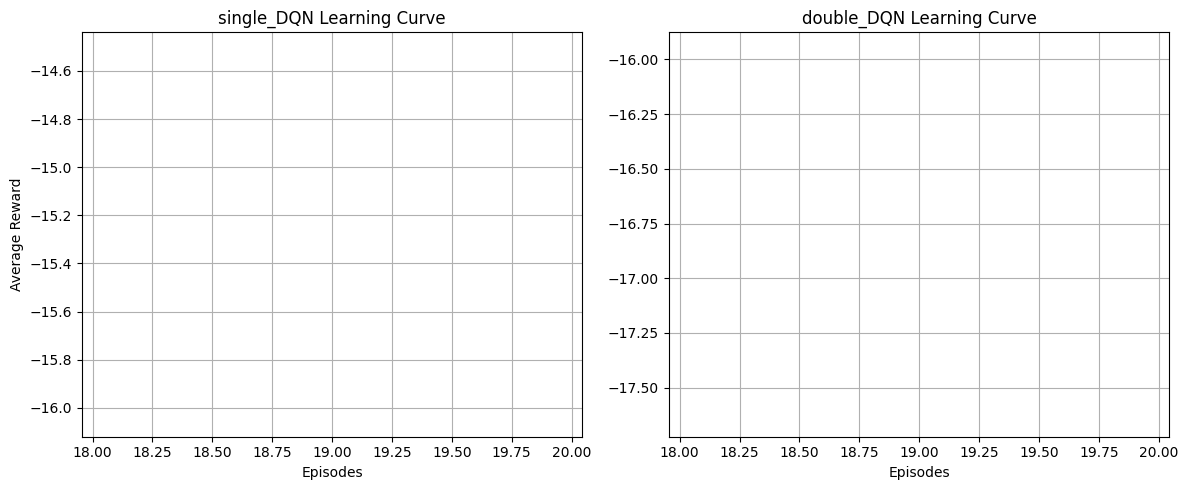

In [20]:
# ---- plotting.py ----
# python
import os
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys


project_root = Path.cwd()

def rolling_avg(arr: List[float], w: int) -> np.ndarray:
    if len(arr) == 0:
        return np.array([])
    if len(arr) < w:
        return np.array([np.mean(arr[: i + 1]) for i in range(len(arr))])
    return np.convolve(arr, np.ones(w) / w, mode="valid")


def plot_learning_curves(
    episode_rewards_single,
    episode_rewards_double,
    window_size: int = 100,
    save_path: str | None = None,
):
    ra_single = rolling_avg(episode_rewards_single, window_size)
    ra_double = rolling_avg(episode_rewards_double, window_size)

    print(
        f"[PLOT] single episodes={len(episode_rewards_single)}, "
        f"double episodes={len(episode_rewards_double)}"
    )

    plt.figure(figsize=(12, 5))

    # Single
    plt.subplot(1, 2, 1)
    if len(ra_single) > 0:
        x_s = np.arange(window_size - 1, window_size - 1 + len(ra_single))
        plt.plot(x_s, ra_single, label="single_DQN (avg)")
    else:
        plt.text(
            0.5,
            0.5,
            "No single_DQN rewards",
            horizontalalignment="center",
            transform=plt.gca().transAxes,
        )
    plt.title("single_DQN Learning Curve")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.grid(True)

    # Double
    plt.subplot(1, 2, 2)
    if len(ra_double) > 0:
        x_d = np.arange(window_size - 1, window_size - 1 + len(ra_double))
        plt.plot(x_d, ra_double, label="double_DQN (avg)")
    else:
        plt.text(
            0.5,
            0.5,
            "No double_DQN rewards",
            horizontalalignment="center",
            transform=plt.gca().transAxes,
        )
    plt.title("double_DQN Learning Curve")
    plt.xlabel("Episodes")
    plt.grid(True)

    plt.tight_layout()

    if save_path:
        p = Path(save_path)
        p.parent.mkdir(parents=True, exist_ok=True)  # works when parent is '.'
        plt.savefig(p, dpi=150)
        print(f"[PLOT] saved to {p}")
    else:
        plt.show()



data_dir = project_root / "models"
single_rewards_path = data_dir / "episode_rewards_single.npy"
double_rewards_path = data_dir / "episode_rewards_double.npy"

missing = [p for p in (single_rewards_path, double_rewards_path) if not p.exists()]
if missing:
    for p in missing:
        print(f"[ERROR] Missing file: `{p}` (expected under `50k_steps/models`).")
    print(f"[INFO] Current working directory: `{Path.cwd()}`")
    sys.exit(1)

single_rewards = np.load(single_rewards_path).tolist()
double_rewards = np.load(double_rewards_path).tolist()

# provide an explicit save path (project root) to avoid empty dirname issues
save_file = data_dir /"learning_curve.png"
plot_learning_curves(
    single_rewards,
    double_rewards,
    window_size=20,
    save_path=str(save_file),
)


In [21]:
import IPython.display as display
import glob
import os
import yaml

def load_config(path: str = "config.yaml") -> dict:
    with open(path, "r") as f:
        return yaml.safe_load(f)

cfg = load_config()

video_paths = [
    cfg["paths"]["video_single_init"],
    cfg["paths"]["video_double_init"],
    cfg["paths"]["video_single_final"],
    cfg["paths"]["video_double_final"],
]

for path in video_paths:
    print(f"\n--- Videos from: {path} ---")
    video_files = glob.glob(os.path.join(path, "*.mp4"))
    if not video_files:
        print(f"No videos found in {path}")
        continue

    for video_file in sorted(video_files):
        print(f"Displaying: {os.path.basename(video_file)}")
        display.display(display.Video(video_file, embed=True, html_attributes="controls"))


--- Videos from: recordings/single_init ---
Displaying: single_DQN_episode_0-episode-0.mp4



--- Videos from: recordings/double_init ---
Displaying: double_DQN_episode_0-episode-0.mp4



--- Videos from: recordings/single_final ---
Displaying: single_DQN_episode_final-episode-0.mp4



--- Videos from: recordings/double_final ---
Displaying: double_DQN_episode_final-episode-0.mp4
